# Unsupervised State-Inference
In reinforcement learning, it's often useful to assume that we can describe a problem in a discrete and finite set of states. For example, we might have an known number of independent bandits, or a grid-world with defined locations of objects. One reason this representation is useful is that it can dramtically simplify the problem of planning: given a known set of states $S$, a transition function $T(s,a,s') = p(s'|s,a)$ that defines the conditional probability of arriving in state $s'$ having taken action $a$ in state $s'$, and reward function $R(s, a, s')$ that defines the values over our state-action space, there are known polynomial time planning algorithms. 

In naturalistic enviornments, however, it can be difficult to translate raw perceptual stimuli into discrete states. Typically, states are an assumption of an enviornment and we often lack a principaled way to discover them from observation alone.  

Here, the goal is to discover states using an unsupervised learning algorithm.  We'll assume states are discrete, independent latent variables and use variational inference to learn conditional probability distribution over states. More formally, given a real-valued observation vector $x\in R^d$, we want to learn a paramterized function $f_\theta(x)$ that defines a probability distribution over states $s$. We'll assume that we don't have access to the states, but only have the observation tuples $(x, x')$ that define transitions an agent makes in an enviornment. We will use a discrete variaitional autoencoder (VAE) for our unsupervised algorithm.




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.utils.data as data
from sklearn.metrics import pairwise_distances
from state_inference.model.tabular_models import TabularRewardEstimator, TabularTransitionEstimator, value_iteration
from state_inference.utils.pytorch_utils import train_epochs, convert_float_to_8bit, make_tensor, convert_8bit_array_to_float_tensor, convert_8bit_to_float
from value_iteration.environments.thread_the_needle import make_thread_the_needle_walls
from state_inference.gridworld_env import OpenEnv
from state_inference.utils.training_utils import parse_config

from state_inference.utils.utils import BayesianFilter
from state_inference.model.tabular_models import StateReconstruction
from state_inference.gridworld_env import TransitionModel, sample_random_walk_states, sample_states
from state_inference.model.vae import (
    DEVICE, Encoder, Decoder, StateVae
    )
from state_inference.utils.data import ObservationDataset

from sklearn.metrics import pairwise_distances


In [3]:
import sys

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")

python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
torch 2.0.1
device = mps


## Toy World
First, it's useful to construct a toy world and the stimuli we'll need for the model. I'm making the assumption that the underlying MDP is a $n\times n$ grid-world that's embedded in much higher dimensional observational space. To do so, I'll construct a much larger grid with dimensions $m\times m$, where $m > n$, and evenly space the states in the grid. I then add a couple of sources of noise and convole the observations with a Gaussian kernel to generate the observations.  This increases the dimensionality substantially (going from $n^2$ to $m^2$) and adds significant overlap between the observations.

We can think of these observations as a toy model for soemthing like a robot's estimate of it's position, or a perhaps as a model of hippocampal grid cells.  Importantly, this doesn't have to be exclusively a spatial model -- none of the subsequent modeling uses visual inductive biases and I'm hopeful this is more general toy model.

In [4]:
CONFIG_FILE = "state_inference/env_config.yml"
TASK_NAME = "thread_the_needle"
TASK_CLASS = OpenEnv

env_kwargs, training_kwargs = parse_config(TASK_NAME, CONFIG_FILE)
task = TASK_CLASS.create_env(**env_kwargs)
observation_model = task.observation_model

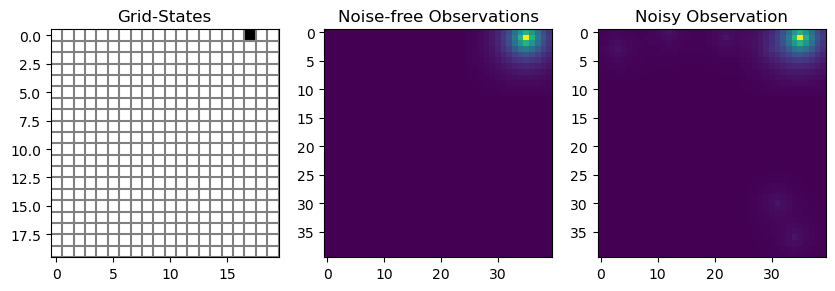

In [5]:
# Discritized states: a 20x20 grid of states, which we embed by spacing
# evenly in a nXn space

# show an example location
s = 17
observation_model.display_state(s)

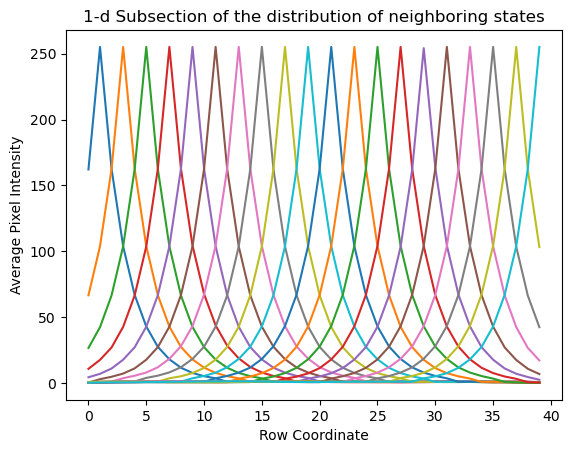

In [6]:
## show the 1-d overlap of neighboring states
x, _ = observation_model.get_obs_coords(26)

for s in range(20, 40):
    obs = torch.mean(
        torch.stack(
            [
                make_tensor(observation_model.embed_state_corrupted(s))[x, :]
                for _ in range(100)
            ]
        ),
        axis=0,
    )
    plt.plot(obs)

plt.xlabel("Row Coordinate")
plt.ylabel("Average Pixel Intensity")
plt.title("1-d Subsection of the distribution of neighboring states")
plt.show()

Notably, there is a overlap in our observation space. We can control this overlap parametrically by changing the length scale of our convolution kernel (this is akin to a wider belief distribution)

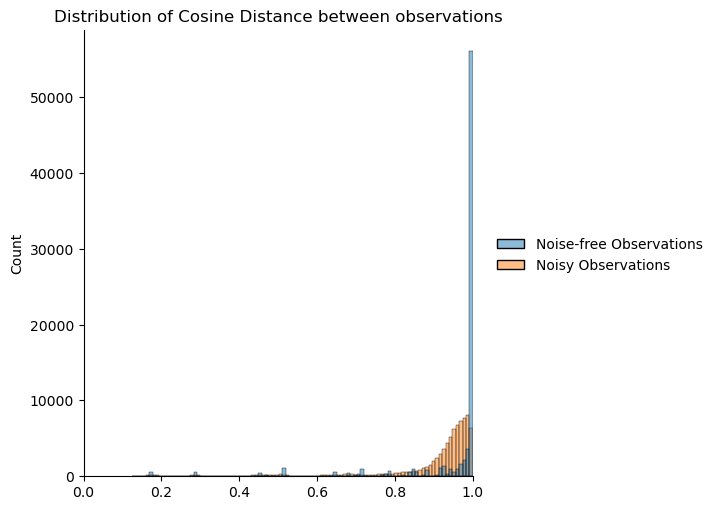

In [7]:
def embed_dist(observation_model, corrupt=False):
    def embed(s):
        if corrupt:
            return observation_model.embed_state_corrupted(s).reshape(-1)
        return observation_model.embed_state(s).reshape(-1)

    sample_embeddings = {s: embed(s) for s in observation_model.states.keys()}

    distances = pairwise_distances(
        np.array(list(sample_embeddings.values())), metric="cosine"
    )

    mask = np.tril(np.ones_like(distances, dtype=bool), k=-1)
    return distances.reshape(-1)[mask.reshape(-1)]


sns.displot(
    {
        "Noise-free Observations": embed_dist(observation_model, corrupt=False),
        "Noisy Observations": embed_dist(observation_model, corrupt=True),
    },
    bins=100,
)

plt.title("Distribution of Cosine Distance between observations")
plt.xlim([0, 1])
plt.show()

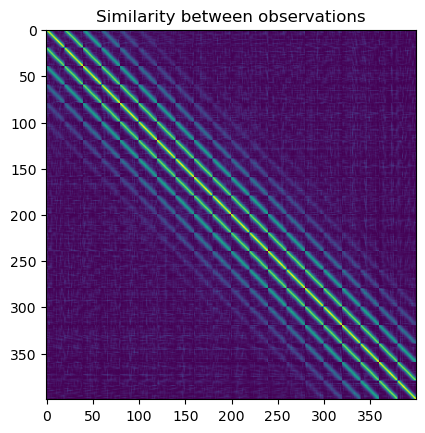

In [8]:
def sample_embedding_distances():
    sample_embeddings = {}
    for s in observation_model.states.keys():
        sample_embeddings[s] = observation_model(s).reshape(-1)

    embedding_distances = 1 - pairwise_distances(
        np.array(list(sample_embeddings.values())), metric="cosine"
    )
    return embedding_distances


embedding_distances = sample_embedding_distances()
plt.title("Similarity between observations")
plt.imshow(embedding_distances)

In [9]:
mask = np.triu(np.ones((400, 400)), k=1).reshape(-1)
np.mean(embedding_distances.reshape(-1)[mask == 1])

0.09290178759978177

In [10]:
def sample_embedding_distances():
    sample_embeddings = {}
    for s in observation_model.states.keys():
        sample_embeddings[s] = observation_model(s).reshape(-1)

    sample_embeddings_2 = {}
    for s in observation_model.states.keys():
        sample_embeddings_2[s] = observation_model(s).reshape(-1)
    # print(sample_embeddings)

    embedding_distances = 1 - pairwise_distances(
        np.array(list(sample_embeddings_2.values())),
        np.array(list(sample_embeddings.values())),
        metric="cosine",
    )
    return embedding_distances


embedding_distances_self = sample_embedding_distances()
# plt.title("Similarity between observations")
# plt.imshow(embedding_distances)
np.diag(embedding_distances_self).mean()

0.9826368123601167

## Discrete State-VAE
The core idea is to use a discrete Variational Autoencoder, where states are represented as one-hot vector embeddings. The VAE is an encoder/decoder model, where the encoder learns a parameterized probability distribution over embeddings and the decoder reconstructs the original input vector from the vector embedding. 

The model has three key components:
* An encoder model: $f_\theta(x) = \omega$
* A Gumbel-Sofmax probability distribution over states $p_\omega(z) \propto exp(\omega + \epsilon)$, where $ \epsilon$ is an external source of noise drawn from the Gumbel distribution.
* A decoder model: $d_\theta(z) = x$

The model is trained with stochastic variational gradient descent: an input is passed through the decoder, a state is sampled from the Gumbel-softmax distribution, and the input is reconstructed by the decoder. This forward pass is used to calculate the ELBO loss function:
$$ELBO(x) = \log q(x|z) - KL(q(z|x)||p(z))$$
where $\log q(x|z)$ is the reconstruction loss of the network and $KL(q(z|x)||p(z))$ is the KL diveregence of the learned embedding distribution and a prior over states. Under gentle assumptions, $-\log q(x|z)$ is the mean squared error of the reconstructed output relative to the input and the $KL(q(z|x)||p(z))$ becomes the entropy of the embedding distribution.




### Generate Dataset
Sample states from a Random walk on the grid-world and then generate noisy observations

In [11]:
## Simulation Parameters
N_TRAINING_EXAMPLES = 10000
BATCH_SIZE = 64

transition_model = TransitionModel(task.observation_model.h, task.observation_model.w)

# Create the dataloaders from the dataset
args = [transition_model, observation_model]
train_obs = ObservationDataset(*args, N_TRAINING_EXAMPLES)
test_obs = ObservationDataset(*args, train=False)

train_loader = data.DataLoader(
    train_obs,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = data.DataLoader(test_obs, batch_size=BATCH_SIZE)

### Train the Model

In [12]:
### Model + Training Parameters
N_EPOCHS = 20  # should be 20
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(observation_model.states) // 2
# EMBEDDING_DIM = 10
OBSERVATION_DIM = observation_model.map_height**2
LR = 3e-4
beta = 1.0
tau = 2.0
gamma = 0.99
dropout = 0.1

# create the model
encoder_hidden = [OBSERVATION_DIM // 5, OBSERVATION_DIM // 10]
decoder_hidden = [OBSERVATION_DIM // 10, OBSERVATION_DIM // 5]
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS

encoder = Encoder(
    OBSERVATION_DIM,
    encoder_hidden,
    z_dim,
    dropout=dropout,
)

decoder = Decoder(
    z_dim,
    decoder_hidden,
    OBSERVATION_DIM,
    dropout=dropout,
)

vae_kwargs = dict(
    z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS, beta=beta, tau=tau, gamma=gamma
)

vae_model = StateVae(encoder, decoder, **vae_kwargs).to(DEVICE)
print(vae_model)

StateVae(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=1600, out_features=320, bias=True)
      (1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=320, out_features=160, bias=True)
      (5): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.1, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=160, out_features=1000, bias=True)
      (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=1000, out_features=160, bias=True)
      (1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=160, out_features=320, bias=True)
      (5): BatchNorm1

In [13]:
# Train the the model
train_losses, test_losses = train_epochs(
    vae_model, train_loader, test_loader, dict(epochs=N_EPOCHS, lr=LR, clip_grad=True)
)

Epoch 0, ELBO Loss (test) 3.151998
Epoch 1, ELBO Loss (test) 2.337662
Epoch 2, ELBO Loss (test) 1.704328
Epoch 3, ELBO Loss (test) 1.439672
Epoch 4, ELBO Loss (test) 1.095723
Epoch 5, ELBO Loss (test) 0.853619
Epoch 6, ELBO Loss (test) 0.625118
Epoch 7, ELBO Loss (test) 0.492798
Epoch 8, ELBO Loss (test) 0.352554
Epoch 9, ELBO Loss (test) 0.315088
Epoch 10, ELBO Loss (test) 0.269295
Epoch 11, ELBO Loss (test) 0.227669
Epoch 12, ELBO Loss (test) 0.160673
Epoch 13, ELBO Loss (test) 0.155302
Epoch 14, ELBO Loss (test) 0.122433
Epoch 15, ELBO Loss (test) 0.135548
Epoch 16, ELBO Loss (test) 0.121532
Epoch 17, ELBO Loss (test) 0.116755
Epoch 18, ELBO Loss (test) 0.098610
Epoch 19, ELBO Loss (test) 0.077576


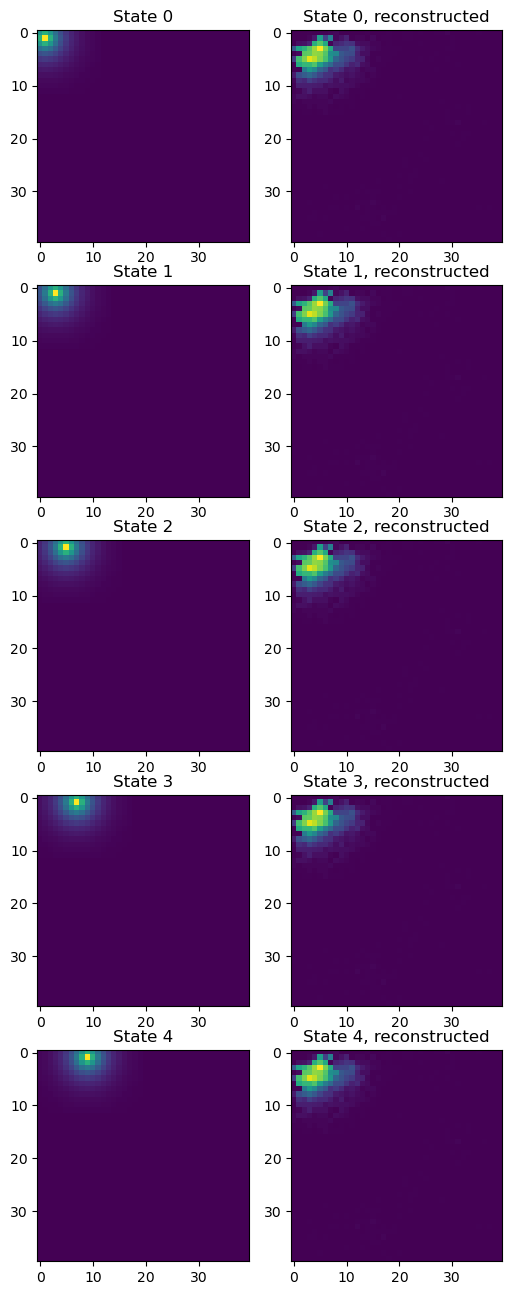

In [14]:
vae_model.eval()
s = np.random.randint(0, EMBEDDING_DIM)
ii = 0
fig, axes = plt.subplots(5, 2, figsize=(6, 16))
for s in range(5):
    _, X_hat = vae_model(test_obs[s, :][None, ...].to(DEVICE))

    axes[ii][0].imshow(convert_float_to_8bit(test_obs[s, :]))
    axes[ii][1].imshow(convert_float_to_8bit(X_hat.squeeze().detach().cpu()).numpy())
    axes[ii][0].set_title(f"State {ii}")
    axes[ii][1].set_title(f"State {ii}, reconstructed")

    ii += 1

### Evaluate the consistency of the inferred states

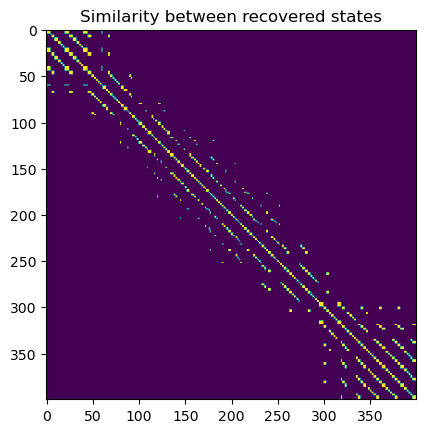

In [15]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = vae_model.get_state(obs)

hash_vector = np.array([vae_model.z_dim**ii for ii in range(vae_model.z_layers)])

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.title("Similarity between recovered states")
plt.imshow(d)

In [16]:
d.mean()

0.019025

In [17]:
obs_a = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)

obs_b = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)

z_a = vae_model.get_state(obs_a)
z_b = vae_model.get_state(obs_a)

d_emb = pairwise_distances(
    obs_a.view(400, -1).cpu().detach().numpy(),
    obs_b.view(400, -1).cpu().detach().numpy(),
)

d_latent = pairwise_distances(
    z_a, z_b, metric=lambda x, y: np.sum(x0 != y0 for x0, y0 in zip(x, y))
)

/var/folders/fm/4kcsh05n3y34x3qkmmlmn6900000gn/T/ipykernel_43500/1477510830.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  z_a, z_b, metric=lambda x, y: np.sum(x0 != y0 for x0, y0 in zip(x, y))


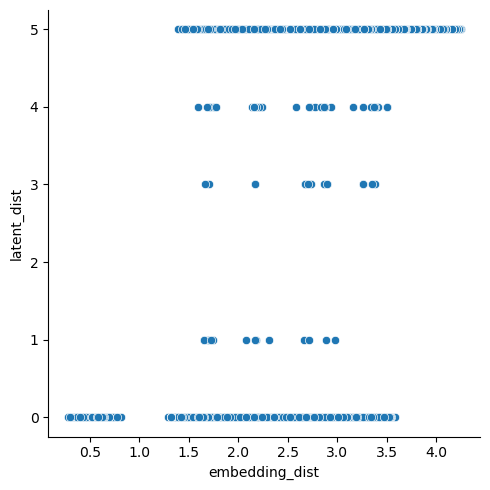

In [18]:
import pandas as pd

# plt.scatter(d_emb.reshape(-1), d_latent.reshape(-1))
sns.relplot(
    data=pd.DataFrame(
        {"latent_dist": d_latent.reshape(-1), "embedding_dist": d_emb.reshape(-1)}
    ),
    x="embedding_dist",
    y="latent_dist",
)

In [19]:
# pd.DataFrame(
#     {
#         "latent_dist": d_latent.reshape(-1),
#         "embedding_dist": d_emb.reshape(-1),
#         "same_state": np.eye(400 * 400).reshape(-1) == 1,
#     },
# )

In [26]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)
euc

array([[ 0.,  1.,  2., ..., 36., 37., 38.],
       [ 1.,  0.,  1., ..., 35., 36., 37.],
       [ 2.,  1.,  0., ..., 34., 35., 36.],
       ...,
       [36., 35., 34., ...,  0.,  1.,  2.],
       [37., 36., 35., ...,  1.,  0.,  1.],
       [38., 37., 36., ...,  2.,  1.,  0.]])

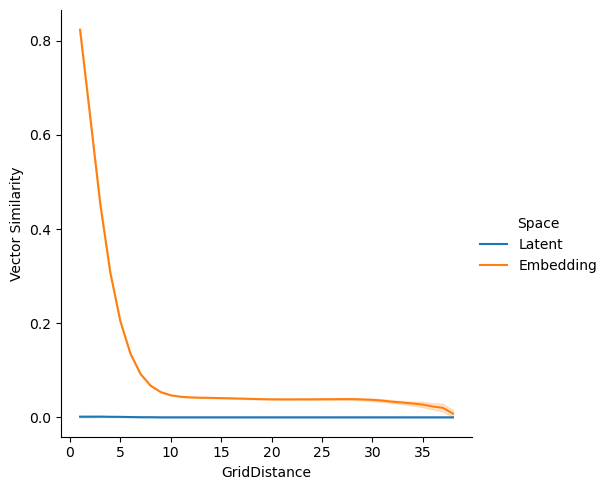

In [27]:
import pandas as pd

_df = pd.concat(
    [
        pd.DataFrame(
            {
                "Space": ["Latent"] * 160000,
                "Vector Similarity": d.reshape(-1) == 1,
                "GridDistance": euc.reshape(-1),
            }
        ),
        pd.DataFrame(
            {
                "Space": ["Embedding"] * 160000,
                "Vector Similarity": embedding_distances.reshape(-1),
                "GridDistance": euc.reshape(-1),
            }
        ),
    ]
)


sns.relplot(
    _df[_df.GridDistance > 0],
    x="GridDistance",
    y="Vector Similarity",
    hue="Space",
    kind="line",
)

/var/folders/fm/4kcsh05n3y34x3qkmmlmn6900000gn/T/ipykernel_43500/3508269178.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  d = pairwise_distances(z, metric=lambda x, y: np.sum(x0 == y0 for x0, y0 in zip(x, y)))


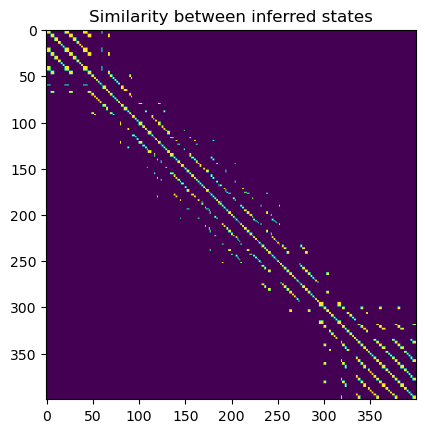

In [28]:
# noise free
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(observation_model(s))
            for s in range(transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = vae_model.get_state(obs)
z
# hash_vector = np.array(
#             [
#                 vae_model.z_dim**ii
#                 for ii in range(vae_model.z_layers)
#             ]
#         )

# z = z.dot(hash_vector)
d = pairwise_distances(z, metric=lambda x, y: np.sum(x0 == y0 for x0, y0 in zip(x, y)))
plt.title("Similarity between inferred states")
plt.imshow(d)

In [29]:
d.mean()

0.0964

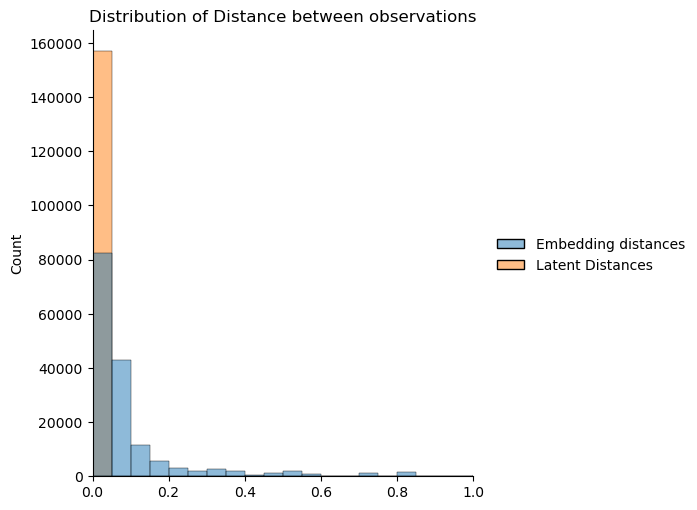

In [30]:
sns.displot(
    {
        "Embedding distances": embedding_distances.reshape(-1),
        "Latent Distances": d.reshape(-1),
    },
    bins=100,
)

plt.title("Distribution of Distance between observations")
plt.xlim([0, 1])
# plt.yscale('log')
plt.show()

# Transition Model
The idea here is to uses Bayesian filtering to smooth the observations model. Formally, if the observation model is 
$p_\omega(z|o)$, we want some model $p_\theta(z'|z)$



### Evaluate State-Inference


In [25]:
n = HEIGHT * WIDTH * 100

# generate a new set of observations for training
y_train = sample_states(transition_model, n)

# Use a trained classifier to determine states from latent representation
recon_model = StateReconstruction(vae_model, observation_model, y_train)

NameError: name 'HEIGHT' is not defined

In [ ]:
# from state_inference.tabular_models import StateReconstruction

n = 500
epsilon = 1e-10  # for numerical stability
y_test = sample_random_walk_states(transition_model, n, 0)
y_hat_logprob = np.log(recon_model.predict_prob(y_test) * (1 - epsilon) + epsilon)

acc_obs_model = recon_model.accuracy(y_hat_logprob, y_test)
print(f"State Inference Accuracy (observation model)      : {acc_obs_model.mean():.4f}")

epsilon = 0.0001  # epsilon smoothing helps with numerical stability

filtered_state_prob = BayesianFilter(
    y_hat_logprob,
    np.log(transition_model.random_transitions * (1 - epsilon) + epsilon),
)
acc_smooth_model = recon_model.accuracy(filtered_state_prob, y_test)
print(
    f"State Inference Accuracy (w/ transition smoothing): {acc_smooth_model.mean():.4f}"
)

In [ ]:
idx = 50
fig, axes = plt.subplots(1, 3)
axes[0].imshow(np.exp(y_hat_logprob[idx].reshape(20, 20)))
axes[1].imshow(np.exp(filtered_state_prob[idx].reshape(20, 20)))
axes[2].imshow(
    np.exp(filtered_state_prob[idx].reshape(20, 20))
    - np.exp(y_hat_logprob[idx].reshape(20, 20))
)
axes[0].set_title("Observation Model")
axes[1].set_title("Pomdp Filtering")
axes[2].set_title("difference")

# Value Iteration
Now that we have a state-inference model, we want to take the model to do a planning task.  The first step is to generate a new random walk, where rewards are observed (ideally a much shorter walk) and use these to estimate a transition and reward function.  We can then use value iteration, and re-projecte the value function into the original space for visualization.  

Ultimately, we'd like to use a task.  We could implment DYNA-Q on the state space, and then recreate figure 8.2 from Sutton and Barto (second edition, page 165 below) 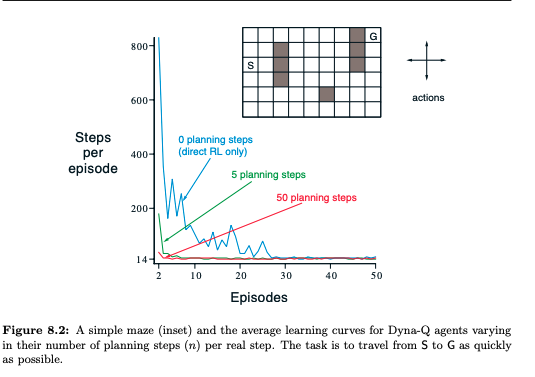

### Transition Function

In [ ]:
thread_the_needle_task = TransitionModel(
    HEIGHT, WIDTH, make_thread_the_needle_walls(20)
)
ax = thread_the_needle_task.display_gridworld()

ax.annotate("G", (0, 0), ha="center", va="center", c="k")
ax.annotate("S", (19, 19), ha="center", va="center", c="k")

## Reward functions

In [ ]:
# Thread the needle reward function
rewards = {ii: 1 for ii in range(0, 10)}
rewards.update({20 * ii: 1 for ii in range(0, 10)})
rewards.update({20 * ii: -1 for ii in range(10, 20)})


# for Display purposes, we can show the reward function embedded in the original
# space.  This doesn't have a clean interpretation, but it shows us
# roughly where pixels are associated with positive or negative reward

reward_map = (
    torch.stack(
        [
            convert_8bit_array_to_float_tensor(observation_model.embed_state(s))[
                None, ...
            ]
            * r
            for s, r in rewards.items()
        ]
    )
    .mean(dim=0)
    .reshape(MAP_HEIGHT, -1)
)

_max = max([abs(reward_map.min()), abs(reward_map.max())])
plt.imshow(reward_map, cmap="bwr", vmin=-_max, vmax=_max)
plt.title("Reward * Embedding")
plt.colorbar()
plt.show()

In [ ]:
from collections import Counter

n = 100000

walk = sample_random_walk_states(transition_model, n, 0)
state_counts = Counter(walk)
state_counts = np.array([state_counts[ii] for ii in range(transition_model.n_states)])

# state_counts, walk = thread_the_needle_task.generate_random_walk(n, 0)
ax = thread_the_needle_task.display_gridworld()
plt.imshow(1 - state_counts.reshape(HEIGHT, WIDTH), cmap="gray")
plt.title(f"State visitations \n in random walk of {n} steps")
plt.show()

# observation_model()
walk_observations = torch.stack(
    [convert_8bit_array_to_float_tensor(observation_model(s)).view(-1) for s in walk]
)
walk_rewards = [rewards.get(s, 0) for s in walk]

## Value iteration

In [ ]:
walk_states = vae_model.get_state(walk_observations.to(DEVICE))
walk_states = [tuple(s) for s in walk_states]

transition_model_tab = TabularTransitionEstimator()
transition_model_tab.batch_update(walk_states)

reward_model = TabularRewardEstimator()
reward_model.batch_update(walk_states, walk_rewards)

In [ ]:
q, v = value_iteration(
    {"N": transition_model_tab}, reward_model, gamma=0.80, iterations=100
)

In [ ]:
v_s = np.zeros((1, HEIGHT * WIDTH))
for z, vz in v.items():
    ps = recon_model.predict_state_prob_from_z([z])
    v_s += ps * vz

# plt.imshow(v_s.reshape(HEIGHT, WIDTH))

ax = thread_the_needle_task.display_gridworld()
plt.imshow(v_s.reshape(HEIGHT, WIDTH), cmap="bwr")
plt.title(f"Reward Value \n in random walk of {n} steps")
plt.colorbar()
plt.show()

In [ ]:
value_function = []
for s, vs in v.items():
    x = vae_model.decode_state(s)
    value_function.append(x * vs)

plt.imshow(
    np.array(value_function).squeeze().mean(axis=0).reshape(MAP_HEIGHT, -1), cmap="bwr"
)

# plt.imshow(reward_map, cmap="bwr")
plt.title("Value Function")
plt.colorbar()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(1 - state_counts.reshape(HEIGHT, WIDTH), cmap="gray")
axes[0].set_title(f"State visitations \n in random walk of {n} steps")
thread_the_needle_task.display_gridworld(ax=axes[0])

mappable = axes[1].imshow(v_s.reshape(HEIGHT, WIDTH), cmap="viridis")
axes[1].set_title(f"Reward Value \n over grid-states")
thread_the_needle_task.display_gridworld(ax=axes[1])
# fig.colorbar(ax=axes[1])

axes[2].imshow(
    np.array(value_function).squeeze().mean(axis=0).reshape(MAP_HEIGHT, -1),
    cmap="viridis",
)
axes[2].set_title("Value Function \n over the observation space")

plt.show()